In [218]:
import sys
KITTI_ROOT_PATH = '/home/ruizhu/Documents/Datasets/kitti'
sys.path.append(KITTI_ROOT_PATH+'/kitti-lidar-utils')
sys.path.append(KITTI_ROOT_PATH+'/kitti-lidar-utils/source')
sys.path.append(KITTI_ROOT_PATH+'/depth/devkit/python')

import numpy as np
np.set_printoptions(precision=4, suppress=True)

%reload_ext autoreload
%autoreload 2

from scipy.io import savemat
import itertools
import pdb
import os
from PIL import Image, ImageOps
import imageio
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import time
from source.utils import load_tracklets_for_frames, point_inside, in_hull
from source import parseTrackletXML as xmlParser
from source.kitti_util import *
import argparse
from matplotlib import cm
from math import atan2, degrees
from PIL import Image
from read_depth import *
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
import torch

import dsac_tools.utils_F as utils_F
import dsac_tools.utils_geo as utils_geo
import dsac_tools.utils_misc as utils_misc
import dsac_tools.utils_vis as utils_vis
import dsac_tools.utils_opencv as utils_opencv
from dsac_tools.H_loss import HLoss
from dsac_tools.dsac import DSAC

from kitti_tools.utils_kitti import *
kitti_two_frame_loader = KittiLoader(KITTI_ROOT_PATH)

## Select sequence
date_name = '2011_09_26'
seq_name = '0005'

kitti_two_frame_loader.set_drive(date_name, seq_name)
kitti_two_frame_loader.get_left_right_gt()
kitti_two_frame_loader.load_cam_poses()
# kitti_two_frame_loader.show_demo()
kitti_two_frame_loader.rectify_all(visualize=False)

## Help functions and plot params
fig_scale = 300
fig_ratio = [4, 3]
im_shape = kitti_two_frame_loader.im_shape

Finished rectifying all frames.


## Get two frames

In [518]:
scipy.io.savemat('testX.mat', {'X': X_rect_i_vis, 'mask': inlier_mask})

In [240]:
i = 0
dsac_errors = {}
opencv_5point_errors = {}
opencv_8point_errors = {}

from IPython.display import clear_output

Between frame 0 and 1: The rotation angle (degree) 0.9407, and translation angle (degree) 2.4650
-- delta_Rtij_gt (scene)
 [[ 0.9999  0.0005  0.0157  0.0088]
 [-0.0005  1.     -0.0046  0.0056]
 [-0.0157  0.0046  0.9999 -0.3418]]
-- delta_Rtij_inv_gt (camera)
 [[ 0.9999 -0.0005 -0.0157 -0.0141]
 [ 0.0005  1.      0.0046 -0.004 ]
 [ 0.0157 -0.0046  0.9999  0.3417]]
-- E_gt (scene)
 [[-0.0003  0.3418  0.004 ]
 [-0.3416 -0.0002 -0.0141]
 [-0.0056  0.0088 -0.0001]]
SP matches:  308


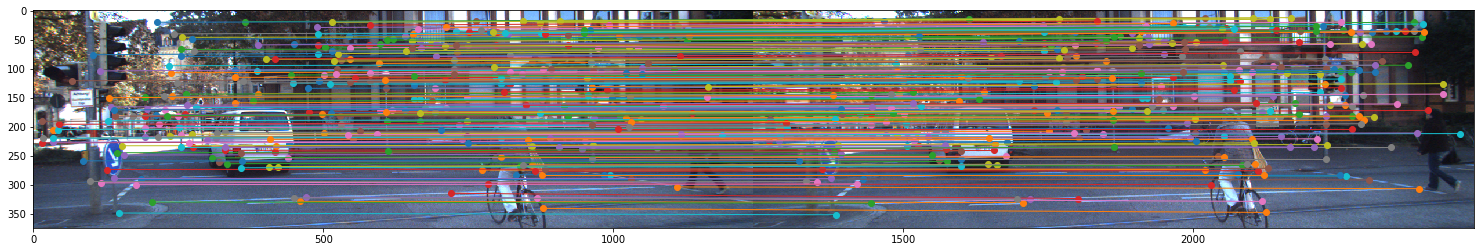

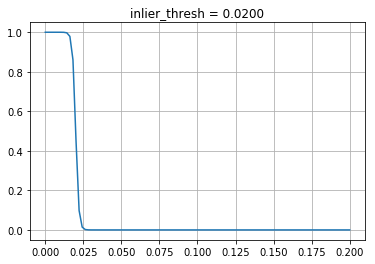

>>>>>>>>>>>>>>>> Check with best 20 corres. ---------------
--- Best 10 errors [0.     0.     0.     0.     0.     0.     0.0001 0.0001 0.0001 0.0001]


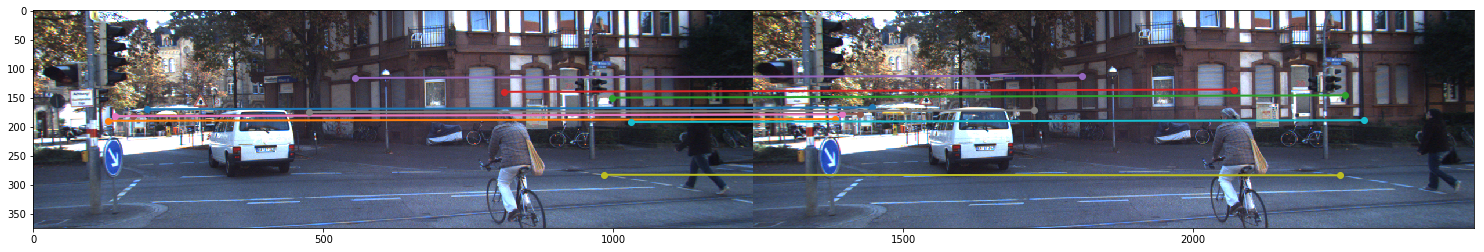

--- F GT
 [[-0.      0.     -0.0001]
 [-0.     -0.      0.0004]
 [ 0.0001 -0.0004  0.0023]]
--- F opencv
 [[-0.      0.     -0.0001]
 [-0.     -0.      0.0004]
 [ 0.0001 -0.0004  0.0023]]
[info.Debug@_F_from_XY] Singualr values of XX:
 [9.0979 6.7709 1.5884 1.2717 0.2333 0.0765 0.0031 0.0006 0.0001]
--- F est (should agree with F opencv)
 [[-0.      0.     -0.0001]
 [-0.     -0.      0.0004]
 [ 0.0001 -0.0004  0.0023]]
--- 76/308 inliers for estimated F.
[info.Debug @_E_from_XY] Singualr values of XX:
 [9.0979 6.7709 1.5884 1.2717 0.2333 0.0765 0.0031 0.0006 0.0001]
[info.Debug @_E_from_XY] Singular values for recovered E(F):
 [0.7084 0.7058 0.    ]
[info.Debug @vali_with_best_M] Singular values for recovered E:
 [9.0042 8.9738 0.    ]
[0, 17, 0, 0]
The 1_th Rt meets the Cheirality Condition! with [R|t] (camera):
 [[ 0.9999 -0.0006 -0.0163 -0.0134]
 [ 0.0006  1.      0.0046 -0.009 ]
 [ 0.0163 -0.0046  0.9999  0.9999]]
Recovered by OpenCV (camera): The rotation error (degree) 0.0329, an

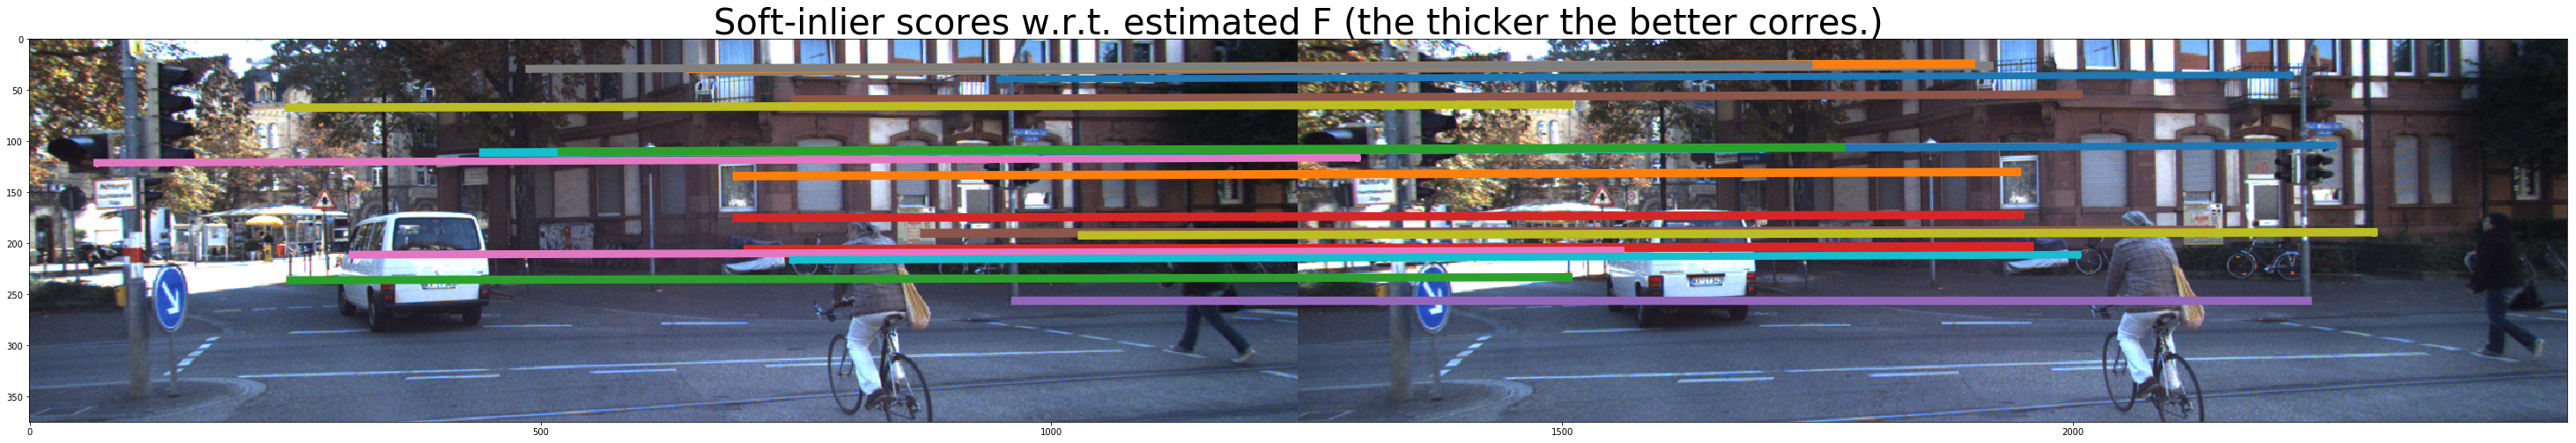

-- E_est & E_gt [[ 0.0001  0.2684 -0.0333]
 [-0.2704  0.0002  0.2039]
 [ 0.0328 -0.2121  0.0015]]
[[-0.0003  0.3418  0.004 ]
 [-0.3416 -0.0002 -0.0141]
 [-0.0056  0.0088 -0.0001]]
# 87/308 inliers from DSAC.
[[ 0.9997  0.0016  0.0228  0.6173]
 [-0.0016  1.     -0.003   0.095 ]
 [-0.0228  0.003   0.9997  0.781 ]] 0.9999999999999992
[[ 0.9997  0.0016  0.0228 -0.6173]
 [-0.0016  1.     -0.003  -0.095 ]
 [-0.0228  0.003   0.9997 -0.781 ]] 0.9999999999999992
[[-0.2601  0.1197  0.9581  0.6173]
 [ 0.1154 -0.9813  0.154   0.095 ]
 [ 0.9587  0.1506  0.2415  0.781 ]] 0.9999999999999993
[[-0.2601  0.1197  0.9581 -0.6173]
 [ 0.1154 -0.9813  0.154  -0.095 ]
 [ 0.9587  0.1506  0.2415 -0.781 ]] 0.9999999999999993
[0, 5, 0, 0]
The 1_th Rt meets the Cheirality Condition! with [R|t] (camera):
 [[ 0.9997 -0.0016 -0.0228  0.5991]
 [ 0.0016  1.      0.003   0.0983]
 [ 0.0228 -0.003   0.9997  0.7946]]
Recovered by DSAC (camera): The rotation error (degree) 0.4215, and translation error (degree) 39.8310
[[ 0

In [247]:
# %reload_ext autoreload
%autoreload 2
delta_i = 1
# i = np.random.randint(kitti_two_frame_loader.N_frames-delta_i)
i = 0

while i + delta_i < kitti_two_frame_loader.N_frames:
#     clear_output()
    j = i + delta_i

    # Get two frames
    X_rect_i, X_rect_i_vis, delta_Rtij, delta_Rtij_inv, img1_rgb, img2_rgb = kitti_two_frame_loader.get_ij(i, j, visualize=False)
    # X_rect_i, X_rect_i_vis, delta_Rtij, delta_Rtij_inv, img1_rgb, img2_rgb = kitti_two_frame_loader.get_i_lr(i, visualize=False)

    print('-- delta_Rtij_gt (scene)\n', delta_Rtij)
    print('-- delta_Rtij_inv_gt (camera)\n', delta_Rtij_inv)
    E_gt_th, F_gt_th = utils_F._E_F_from_Rt(delta_Rtij[:, :3], delta_Rtij[:, 3:4], kitti_two_frame_loader.K)    
    F_gt = F_gt_th.numpy()
    E_gt_th_inv, F_gt_th_inv = utils_F._E_F_from_Rt(delta_Rtij_inv[:, :3], delta_Rtij_inv[:, 3:4], kitti_two_frame_loader.K)    
    F_gt_inv = F_gt_th_inv.numpy()
    R2s, t2s, M2s = utils_F._get_M2s(E_gt_th)
    print('-- E_gt (scene)\n', E_gt_th.numpy())

    img1_rgb_np, img2_rgb_np = np.array(img1_rgb), np.array(img2_rgb)
    img1, img2 = utils_opencv.PIL_to_gray(img1_rgb), utils_opencv.PIL_to_gray(img2_rgb)

#     # Keypoint detection and matching with SIFT
#     x1_all, kp1, des1 = utils_opencv.SIFT_det(img1, img1_rgb, visualize=False)
#     x2_all, kp2, des2 = utils_opencv.SIFT_det(img2, img2_rgb, visualize=False)
#     x1, x2 = utils_opencv.KNN_match(des1, des2, x1_all, x2_all, kp1, kp2, img1_rgb, img2_rgb, visualize=False)

    # Keypoint detection and matching with SuperPoint inference model
    sp_pred = sp_inferrer.run_two_imgs(sp_inferrer.img_array_to_input(img1_rgb_np), sp_inferrer.img_array_to_input(img2_rgb_np))
    matches = sp_inferrer.get_matches(sp_pred)
    x1 = matches[0][:, :2]
    x2 = matches[0][:, 2:4]
    utils_vis.draw_corr(img1_rgb_np, img2_rgb_np, x1, x2, 1)
    
    # Sample and check
    random_idx, x1_sample, x2_sample = utils_opencv.sample_and_check(x1, x2, img1_rgb, img2_rgb, img1_rgb_np, img2_rgb_np, F_gt, kitti_two_frame_loader, visualize=False)

    # DSAC
    DSAC_params = {}
    DSAC_params['inlier_beta'] = 1000
    DSAC_params['inlier_thresh'] = 0.02 # HOW TO SET THRES?
    DSAC_params['N_hypotheses'] = 10000
    DSAC_params['inlier_alpha'] = 0.5

    ## Visualize soft-inlier counting function
    a = torch.linspace(0, DSAC_params['inlier_thresh']*10, 100)
    b = 1 - torch.sigmoid(DSAC_params['inlier_beta'] * (a - DSAC_params['inlier_thresh']))
    plt.plot(a.numpy(), b.numpy())
    plt.grid()
    plt.title('inlier_thresh = %.4f'%DSAC_params['inlier_thresh'])
    plt.show()

    ## Validate pose estimation with best 9
    mask_index_9 = utils_F.vali_with_best_M(F_gt_th, E_gt_th, x1, x2, img1_rgb_np, img2_rgb_np, kitti_two_frame_loader, DSAC_params, delta_Rtij_inv)

    # ## Set up DSAC
    loss = HLoss()
    dsac = DSAC(DSAC_params['N_hypotheses'], DSAC_params['inlier_thresh'], DSAC_params['inlier_beta'], DSAC_params['inlier_alpha'], kitti_two_frame_loader.K_th, loss)
    N_scores = dsac(torch.from_numpy(x1), torch.from_numpy(x2), F_gt_th)
    N_scores_np = N_scores.numpy()
    N_scores_np = N_scores_np/np.max(N_scores_np)
    utils_vis.draw_corr_widths(img1_rgb_np, img2_rgb_np, x1_sample, x2_sample, N_scores_np[random_idx]*10+1, 'Soft-inlier scores w.r.t. estimated F (the thicker the better corres.)', False)

    E_est_th = dsac.best_H # actually already E!
    # F_est_th_8 = utils_F._F_from_XY(torch.from_numpy(x1[mask_index_10, :]), torch.from_numpy(x2[mask_index_10, :]))
    # F_est_th = F_est_th_8

    best_corres_idx = dsac.best_corres_idx
    # print('-- F_est & F_gt', (F_est_th / torch.norm(F_est_th) * torch.norm(F_gt_th)).numpy())
    # print(F_gt)

    # E_est_th = utils_F._F_to_E(F_est_th, kitti_two_frame_loader.K_th)
    print('-- E_est & E_gt', (E_est_th / torch.norm(E_est_th) * torch.norm(E_gt_th)).numpy())
    print(E_gt_th.numpy())

    ## Recover [R|t]
    inlier_dists = dsac.sampson_dists.numpy()[dsac.best_H_idx, :]
    inlier_mask = inlier_dists < DSAC_params['inlier_thresh']
    print('# %d/%d inliers from DSAC.'%(np.sum(inlier_mask), inlier_mask.shape[0]))
    M2_list, error_Rt = utils_F._E_to_M(E_est_th, kitti_two_frame_loader.K, x1, x2, inlier_mask, delta_Rtij_inv, show_debug=True, method_name='DSAC')
    dsac_errors['%d'%i] = error_Rt

    ## OpenCV results
    M, error_Rt_5point = utils_opencv.recover_camera_opencv(E_gt_th.numpy(), kitti_two_frame_loader.K, x2, x1, delta_Rtij_inv, five_point=True, threshold=0.01)
#     M, error_Rt_5point = utils_opencv.recover_camera_0(E_gt_th.numpy(), kitti_two_frame_loader.K, x2, x1, delta_Rtij_inv, five_point=True, threshold=0.001)
    opencv_5point_errors['%d'%i] = error_Rt_5point
    M, error_Rt_8point = utils_opencv.recover_camera_opencv(E_gt_th.numpy(), kitti_two_frame_loader.K, x2, x1, delta_Rtij_inv, five_point=False, threshold=0.01)
    opencv_8point_errors['%d'%i] = error_Rt_8point

    print('GT camera matrix: (camera)\n', delta_Rtij_inv)    
    
    break

    clear_output()
    for idx in range(i):
        def format_02f(x_tuple):
            return '(%.2f, %.2f)'%(x_tuple[0], x_tuple[1])
        print('- Frame %d and %d'%(idx, idx+1), format_02f(dsac_errors['%d'%idx]), format_02f(opencv_5point_errors['%d'%idx]), format_02f(opencv_8point_errors['%d'%idx]))
    
    i = i+1

In [243]:
def get_mean_std(errors):
    errors_R = [errors[key][0] for key in errors.keys()]
    errors_t = [errors[key][1] for key in errors.keys()]
    print('error_R = %.4f ± %.4f'%(np.mean(errors_R), np.std(errors_R)), 'error_t = %.4f ± %.4f'%(np.mean(errors_t), np.std(errors_t)))
    #     errors_t = [error[1] for error in errors]
print('DSAC:'); get_mean_std(dsac_errors)
print('OpenCV 5-point:'); get_mean_std(opencv_5point_errors)
print('OpenCV 8-point:'); get_mean_std(opencv_8point_errors)

DSAC:
error_R = 0.1283 ± 0.0905 error_t = 4.9801 ± 10.3773
OpenCV 5-point:
error_R = 0.6803 ± 0.4693 error_t = 64.2246 ± 39.7119
OpenCV 8-point:
error_R = 0.6216 ± 0.6668 error_t = 14.6624 ± 21.8955


# Kitti loader

## Prepare data

In [244]:
%reload_ext autoreload
%autoreload 2
from path import Path
from tqdm import 
from joblib import Parallel, delayed
from kitti_tools.kitti_raw_loader import KittiRawLoader
import argparse
import numpy as np

parser = argparse.ArgumentParser(description='Foo')
parser.add_argument("--dataset_dir", type=str,
                    help='path to original dataset')
parser.add_argument("--dataset-format", type=str, default='kitti', choices=["kitti", "cityscapes"])
parser.add_argument("--static-frames", default=None,
                    help="list of imgs to discard for being static, if not set will discard them based on speed \
                    (careful, on KITTI some frames have incorrect speed)")
# parser.add_argument("--with-depth", action='store_true',
#                     help="If available (e.g. with KITTI), will store depth ground truth along with images, for validation")
parser.add_argument("--with-pose", action='store_true',
                    help="If available (e.g. with KITTI), will store pose ground truth along with images, for validation")
# parser.add_argument("--no-train-gt", action='store_true',
#                     help="If selected, will delete ground truth depth to save space")
parser.add_argument("--dump-root", type=str, default='dump', help="Where to dump the data")
parser.add_argument("--height", type=int, default=128, help="image height")
parser.add_argument("--width", type=int, default=416, help="image width")
# parser.add_argument("--depth-size-ratio", type=int, default=1, help="will divide depth size by that ratio")
parser.add_argument("--num-threads", type=int, default=6, help="number of threads to use")

args = parser.parse_args('--dataset_dir /home/ruizhu/Documents/Datasets/kitti/raw --dataset-format kitti \
--dump-root /home/ruizhu/Documents/Projects/kitti_instance_RGBD_utils/kitti_dump/ --width 1242 --height 375 \
--num-threads 6 --with-pose'.split())
print(args)
args_dump_root = Path(args.dump_root)
args_dump_root.mkdir_p()

data_loader = KittiRawLoader(args.dataset_dir,
                             static_frames_file=None,
                             img_height=args.height,
                             img_width=args.width,
                             get_depth=None,
                             get_pose=args.with_pose)
# drive_path_test = data_loader.get_drive_path('2011_09_26', '0005')
# data_loader.scenes = [drive_path_test]

# Parallel(n_jobs=args.num_threads)(delayed(data_loader.dump_drive)(args, drive_path) for drive_path in tqdm(data_loader.scenes))

print('== Retrieving frames')
for drive_path in tqdm(data_loader.scenes):
    # # scene_list = data_loader.dump_drive(args, drive)
    scene_list = data_loader.collect_scenes(drive_path)
    data_loader.dump_drive(args, drive_path, scene_list)

print('== Generating train val lists')
np.random.seed(8964)
# to avoid data snooping, we will make two cameras of the same scene to fall in the same set, train or val
subdirs = args_dump_root.dirs() # e.g. Path('./data/kitti_dump/2011_09_30_drive_0034_sync_02')
canonic_prefixes = set([subdir.basename()[:-2] for subdir in subdirs]) # e.g. '2011_09_28_drive_0039_sync_'
with open(args_dump_root / 'train.txt', 'w') as tf:
    with open(args_dump_root / 'val.txt', 'w') as vf:
        for pr in tqdm(canonic_prefixes):
            corresponding_dirs = args_dump_root.dirs('{}*'.format(pr)) # e.g. [Path('./data/kitti_dump/2011_09_30_drive_0033_sync_03'), Path('./data/kitti_dump/2011_09_30_drive_0033_sync_02')]
            if np.random.random() < 0.0:
                for s in corresponding_dirs:
                    vf.write('{}\n'.format(s.name))
            else:
                for s in corresponding_dirs:
                    tf.write('{}\n'.format(s.name))
#                     if args.with_depth and args.no_train_gt:
#                         for gt_file in s.files('*.npy'):
#                             gt_file.remove_p()



  0%|          | 0/156 [00:00<?, ?it/s]

Namespace(dataset_dir='/home/ruizhu/Documents/Datasets/kitti/raw', dataset_format='kitti', dump_root='/home/ruizhu/Documents/Projects/kitti_instance_RGBD_utils/kitti_dump/', height=375, num_threads=6, static_frames=None, width=1242, with_pose=True)
== Retrieving frames
Finished rectifying all frames.
Dumping to  /home/ruizhu/Documents/Projects/kitti_instance_RGBD_utils/kitti_dump/2011_09_26_drive_0091_sync_02




  1%|          | 1/156 [00:57<2:29:18, 57.80s/it]

Finished rectifying all frames.
Dumping to  /home/ruizhu/Documents/Projects/kitti_instance_RGBD_utils/kitti_dump/2011_09_26_drive_0079_sync_02




  1%|▏         | 2/156 [01:06<1:50:52, 43.20s/it]

Finished rectifying all frames.
Dumping to  /home/ruizhu/Documents/Projects/kitti_instance_RGBD_utils/kitti_dump/2011_09_26_drive_0014_sync_02




  2%|▏         | 3/156 [01:56<1:55:00, 45.10s/it]

Finished rectifying all frames.
Dumping to  /home/ruizhu/Documents/Projects/kitti_instance_RGBD_utils/kitti_dump/2011_09_26_drive_0017_sync_02




  3%|▎         | 4/156 [02:06<1:27:40, 34.61s/it]

Finished rectifying all frames.
Dumping to  /home/ruizhu/Documents/Projects/kitti_instance_RGBD_utils/kitti_dump/2011_09_26_drive_0056_sync_02




  3%|▎         | 5/156 [02:51<1:34:49, 37.68s/it]

Finished rectifying all frames.
Dumping to  /home/ruizhu/Documents/Projects/kitti_instance_RGBD_utils/kitti_dump/2011_09_26_drive_0070_sync_02




  4%|▍         | 6/156 [04:13<2:07:24, 50.96s/it]

Finished rectifying all frames.
Dumping to  /home/ruizhu/Documents/Projects/kitti_instance_RGBD_utils/kitti_dump/2011_09_26_drive_0023_sync_02




  4%|▍         | 7/156 [05:48<2:39:28, 64.22s/it]

Finished rectifying all frames.
Dumping to  /home/ruizhu/Documents/Projects/kitti_instance_RGBD_utils/kitti_dump/2011_09_26_drive_0035_sync_02




  5%|▌         | 8/156 [06:01<2:00:08, 48.71s/it]

Finished rectifying all frames.
Dumping to  /home/ruizhu/Documents/Projects/kitti_instance_RGBD_utils/kitti_dump/2011_09_26_drive_0060_sync_02




  6%|▌         | 9/156 [06:06<1:27:53, 35.87s/it]

Finished rectifying all frames.
Dumping to  /home/ruizhu/Documents/Projects/kitti_instance_RGBD_utils/kitti_dump/2011_09_26_drive_0059_sync_02




  6%|▋         | 10/156 [07:12<1:48:55, 44.77s/it]

Finished rectifying all frames.
Dumping to  /home/ruizhu/Documents/Projects/kitti_instance_RGBD_utils/kitti_dump/2011_09_26_drive_0005_sync_02




  7%|▋         | 11/156 [07:30<1:28:49, 36.75s/it]

Finished rectifying all frames.
Dumping to  /home/ruizhu/Documents/Projects/kitti_instance_RGBD_utils/kitti_dump/2011_09_26_drive_0013_sync_02




  8%|▊         | 12/156 [07:45<1:12:29, 30.20s/it]

Finished rectifying all frames.
Dumping to  /home/ruizhu/Documents/Projects/kitti_instance_RGBD_utils/kitti_dump/2011_09_26_drive_0101_sync_02




  8%|▊         | 13/156 [13:38<5:02:43, 127.02s/it]

Finished rectifying all frames.
Dumping to  /home/ruizhu/Documents/Projects/kitti_instance_RGBD_utils/kitti_dump/2011_09_26_drive_0028_sync_02




  9%|▉         | 14/156 [15:08<4:34:16, 115.89s/it]

Finished rectifying all frames.
Dumping to  /home/ruizhu/Documents/Projects/kitti_instance_RGBD_utils/kitti_dump/2011_09_26_drive_0032_sync_02




 10%|▉         | 15/156 [16:18<3:59:54, 102.09s/it]

Finished rectifying all frames.
Dumping to  /home/ruizhu/Documents/Projects/kitti_instance_RGBD_utils/kitti_dump/2011_09_26_drive_0046_sync_02




 10%|█         | 16/156 [16:30<2:55:16, 75.12s/it] 

Finished rectifying all frames.
Dumping to  /home/ruizhu/Documents/Projects/kitti_instance_RGBD_utils/kitti_dump/2011_09_26_drive_0027_sync_02




 11%|█         | 17/156 [16:53<2:17:40, 59.43s/it]

Finished rectifying all frames.
Dumping to  /home/ruizhu/Documents/Projects/kitti_instance_RGBD_utils/kitti_dump/2011_09_26_drive_0064_sync_02




 12%|█▏        | 18/156 [19:17<3:15:16, 84.91s/it]

Finished rectifying all frames.
Dumping to  /home/ruizhu/Documents/Projects/kitti_instance_RGBD_utils/kitti_dump/2011_09_26_drive_0018_sync_02




 12%|█▏        | 19/156 [19:57<2:42:54, 71.35s/it]

Finished rectifying all frames.
Dumping to  /home/ruizhu/Documents/Projects/kitti_instance_RGBD_utils/kitti_dump/2011_09_26_drive_0093_sync_02




 13%|█▎        | 20/156 [21:23<2:52:05, 75.92s/it]

Finished rectifying all frames.
Dumping to  /home/ruizhu/Documents/Projects/kitti_instance_RGBD_utils/kitti_dump/2011_09_26_drive_0002_sync_02




 13%|█▎        | 21/156 [21:30<2:03:47, 55.02s/it]

Finished rectifying all frames.
Dumping to  /home/ruizhu/Documents/Projects/kitti_instance_RGBD_utils/kitti_dump/2011_09_26_drive_0036_sync_02




 14%|█▍        | 22/156 [25:42<4:15:12, 114.28s/it]

Finished rectifying all frames.


AssertionError: [Error] Unequal lengths of imu_pose_matrix:447, val_idxes_list:443, X_rect_list:443!

In [17]:
print('== Generating train val lists')
np.random.seed(8964)
# to avoid data snooping, we will make two cameras of the same scene to fall in the same set, train or val
subdirs = args_dump_root.dirs() # e.g. Path('./data/kitti_dump/2011_09_30_drive_0034_sync_02')
canonic_prefixes = set([subdir.basename()[:-2] for subdir in subdirs]) # e.g. '2011_09_28_drive_0039_sync_'
with open(args_dump_root / 'train.txt', 'w') as tf:
    with open(args_dump_root / 'val.txt', 'w') as vf:
        for pr in tqdm(canonic_prefixes):
            corresponding_dirs = args_dump_root.dirs('{}*'.format(pr)) # e.g. [Path('./data/kitti_dump/2011_09_30_drive_0033_sync_03'), Path('./data/kitti_dump/2011_09_30_drive_0033_sync_02')]
            if np.random.random() < 0.0:
                for s in corresponding_dirs:
                    vf.write('{}\n'.format(s.name))
            else:
                for s in corresponding_dirs:
                    tf.write('{}\n'.format(s.name))
#                     if args.with_depth and args.no_train_gt:
#                         for gt_file in s.files('*.npy'):
#                             gt_file.remove_p()



  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 921.42it/s]

== Generating train val lists


## Demo trainer

In [169]:
%reload_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable
import torch.backends.cudnn as cudnn
import torch.optim
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data

parser = argparse.ArgumentParser(description='Foo')
parser.add_argument("--dump-root", type=str, default='dump', help="Where to dump the data")
parser.add_argument('--seed', default=0, type=int, help='seed for random functions, and network initialization')
parser.add_argument('--sequence-length', type=int, metavar='N', help='sequence length for training', default=2)
parser.add_argument('--epoch-size', default=0, type=int, metavar='N',
                    help='manual epoch size (will match dataset size if not set)')
parser.add_argument('-b', '--batch-size', default=1, type=int, metavar='N', 
                    help='mini-batch size')
parser.add_argument('-j', '--workers', default=4, type=int, metavar='N', 
                    help='number of data loading workers')
parser.add_argument('--epochs', default=200, type=int, metavar='N',
                    help='number of total epochs to run')

args = parser.parse_args('--dump-root /home/ruizhu/Documents/Projects/kitti_instance_RGBD_utils/kitti_dump/ --sequence-length 2'.split())
print(args)

best_error = -1
n_iter = 0
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

from kitti_tools.sequence_folders import SequenceFolder
train_set = SequenceFolder(
        args.dump_root,
        transform=None,
        seed=args.seed,
        train=True,
        sequence_length=args.sequence_length
    )
print('{} samples found in {} train scenes'.format(len(train_set), len(train_set.scenes)))
# imgs, intrinsics, imu_pose_matrixs, scene, frame_ids = train_set.__getitem__(0)

train_loader = torch.utils.data.DataLoader(
        train_set, batch_size=args.batch_size, shuffle=True,
        num_workers=args.workers, pin_memory=True)
if args.epoch_size == 0:
    args.epoch_size = len(train_loader) # len(scenes)//batch_size

def train_one_epoch(args, train_loader, epoch_size):
    global n_iter, device

    for i, (imgs, intrinsics, imu_pose_matrixs, scene_name, frame_ids) in enumerate(train_loader):
        print(imgs[0])
        imgs = [img.to(device) for img in imgs]
        intrinsics = intrinsics.to(device)
        imu_pose_matrixs = [imu_pose_matrix.to(device) for imu_pose_matrix in imu_pose_matrixs]
        frame_ids = [frame_id.to(device) for frame_id in frame_ids]
#         im = imgs[0].cpu().numpy()
#         plt.imshow(np.squeeze(im).astype(np.int32))
#         plt.show()
        
for epoch in range(args.epochs):
    train_loss = train_one_epoch(args, train_loader, args.epoch_size)

Namespace(batch_size=1, dump_root='/home/ruizhu/Documents/Projects/kitti_instance_RGBD_utils/kitti_dump/', epoch_size=0, epochs=200, seed=0, sequence_length=2, workers=4)
153 samples found in 1 train scenes
tensor([[[[15., 15., 15.],
          [14., 14., 14.],
          [14., 14., 14.],
          ...,
          [33., 40., 50.],
          [32., 39., 49.],
          [32., 39., 49.]],

         [[15., 15., 15.],
          [15., 15., 15.],
          [15., 15., 15.],
          ...,
          [33., 40., 50.],
          [33., 40., 50.],
          [33., 40., 50.]],

         [[17., 17., 17.],
          [16., 16., 16.],
          [16., 16., 16.],
          ...,
          [33., 40., 50.],
          [34., 41., 51.],
          [34., 41., 51.]],

         ...,

         [[13., 13., 15.],
          [13., 13., 15.],
          [14., 14., 16.],
          ...,
          [16., 13., 20.],
          [17., 14., 21.],
          [17., 14., 21.]],

         [[14., 14., 16.],
          [14., 14., 16.],
        

tensor([[[[ 65.,  60.,  22.],
          [ 78.,  73.,  31.],
          [106., 100.,  52.],
          ...,
          [ 88.,  64.,  62.],
          [ 87.,  63.,  61.],
          [ 87.,  63.,  61.]],

         [[ 74., 107.,  80.],
          [ 64.,  95.,  64.],
          [ 59.,  85.,  48.],
          ...,
          [ 88.,  64.,  62.],
          [ 87.,  63.,  61.],
          [ 87.,  63.,  61.]],

         [[ 48.,  84.,  72.],
          [ 45.,  79.,  65.],
          [ 44.,  73.,  53.],
          ...,
          [ 85.,  61.,  59.],
          [ 87.,  63.,  61.],
          [ 87.,  63.,  61.]],

         ...,

         [[ 67.,  85.,  97.],
          [ 64.,  82.,  96.],
          [ 59.,  77.,  91.],
          ...,
          [ 45.,  60.,  83.],
          [ 46.,  60.,  86.],
          [ 48.,  60.,  86.]],

         [[ 68.,  86., 100.],
          [ 63.,  80.,  96.],
          [ 57.,  74.,  90.],
          ...,
          [ 45.,  60.,  83.],
          [ 48.,  60.,  84.],
          [ 48.,  60.,  86.]],



tensor([[[[ 21.,  27.,  23.],
          [ 18.,  23.,  19.],
          [ 14.,  16.,  15.],
          ...,
          [255., 255., 255.],
          [255., 255., 255.],
          [255., 255., 255.]],

         [[ 24.,  30.,  26.],
          [ 21.,  25.,  24.],
          [ 17.,  19.,  18.],
          ...,
          [255., 255., 255.],
          [255., 255., 255.],
          [255., 255., 255.]],

         [[ 25.,  31.,  29.],
          [ 23.,  27.,  26.],
          [ 19.,  21.,  20.],
          ...,
          [255., 255., 255.],
          [255., 255., 255.],
          [255., 255., 255.]],

         ...,

         [[ 60.,  65.,  68.],
          [ 58.,  63.,  67.],
          [ 55.,  60.,  64.],
          ...,
          [249., 253., 255.],
          [251., 255., 255.],
          [251., 255., 255.]],

         [[ 43.,  48.,  52.],
          [ 42.,  47.,  51.],
          [ 40.,  45.,  51.],
          ...,
          [246., 250., 253.],
          [250., 254., 255.],
          [250., 254., 255.]],



tensor([[[[47., 66., 62.],
          [44., 56., 54.],
          [40., 42., 41.],
          ...,
          [69., 68., 73.],
          [80., 79., 84.],
          [80., 79., 84.]],

         [[53., 74., 65.],
          [48., 64., 54.],
          [40., 45., 39.],
          ...,
          [86., 85., 90.],
          [88., 87., 92.],
          [88., 87., 92.]],

         [[46., 71., 50.],
          [43., 62., 43.],
          [33., 44., 28.],
          ...,
          [94., 93., 98.],
          [93., 92., 97.],
          [93., 92., 97.]],

         ...,

         [[39., 48., 55.],
          [38., 47., 54.],
          [35., 46., 52.],
          ...,
          [31., 39., 50.],
          [31., 40., 49.],
          [31., 40., 49.]],

         [[38., 51., 57.],
          [37., 50., 56.],
          [38., 49., 55.],
          ...,
          [32., 40., 51.],
          [34., 43., 52.],
          [34., 43., 52.]],

         [[32., 50., 54.],
          [33., 48., 53.],
          [35., 48., 54.],
         

tensor([[[[ 11.,  11.,  11.],
          [ 11.,  11.,  11.],
          [ 12.,  12.,  12.],
          ...,
          [ 30.,  36.,  48.],
          [ 37.,  43.,  55.],
          [ 37.,  43.,  55.]],

         [[ 14.,  14.,  14.],
          [ 14.,  14.,  14.],
          [ 14.,  14.,  14.],
          ...,
          [ 35.,  41.,  53.],
          [ 36.,  42.,  54.],
          [ 36.,  42.,  54.]],

         [[ 17.,  17.,  17.],
          [ 16.,  16.,  16.],
          [ 16.,  16.,  16.],
          ...,
          [ 39.,  45.,  57.],
          [ 36.,  42.,  54.],
          [ 36.,  42.,  54.]],

         ...,

         [[145., 150., 143.],
          [147., 152., 145.],
          [146., 151., 145.],
          ...,
          [234., 245., 251.],
          [234., 245., 251.],
          [231., 244., 250.]],

         [[144., 152., 141.],
          [143., 150., 142.],
          [139., 146., 138.],
          ...,
          [233., 246., 254.],
          [232., 245., 253.],
          [231., 246., 253.]],



tensor([[[[100., 102.,  55.],
          [ 97.,  99.,  59.],
          [ 84.,  89.,  57.],
          ...,
          [ 62.,  76.,  89.],
          [ 61.,  75.,  88.],
          [ 61.,  75.,  88.]],

         [[109., 110.,  66.],
          [109., 111.,  72.],
          [ 94.,  99.,  69.],
          ...,
          [ 62.,  76.,  89.],
          [ 61.,  75.,  88.],
          [ 61.,  75.,  88.]],

         [[130., 128.,  89.],
          [133., 133.,  99.],
          [113., 115.,  91.],
          ...,
          [ 62.,  76.,  89.],
          [ 61.,  75.,  88.],
          [ 61.,  75.,  88.]],

         ...,

         [[ 80.,  81.,  73.],
          [ 78.,  79.,  71.],
          [ 76.,  77.,  69.],
          ...,
          [ 12.,  11.,  16.],
          [ 11.,  10.,  15.],
          [ 11.,  10.,  15.]],

         [[ 80.,  82.,  71.],
          [ 80.,  81.,  73.],
          [ 79.,  80.,  72.],
          ...,
          [ 11.,  10.,  15.],
          [ 10.,   9.,  14.],
          [ 10.,   9.,  14.]],



tensor([[[[ 29.,  23.,  33.],
          [ 31.,  26.,  33.],
          [ 34.,  32.,  37.],
          ...,
          [ 48.,  52.,  63.],
          [ 42.,  46.,  57.],
          [ 41.,  45.,  57.]],

         [[ 29.,  23.,  33.],
          [ 31.,  26.,  33.],
          [ 32.,  30.,  35.],
          ...,
          [ 47.,  51.,  62.],
          [ 42.,  46.,  57.],
          [ 41.,  45.,  57.]],

         [[ 31.,  23.,  34.],
          [ 31.,  26.,  33.],
          [ 33.,  28.,  34.],
          ...,
          [ 46.,  50.,  61.],
          [ 41.,  45.,  56.],
          [ 41.,  45.,  57.]],

         ...,

         [[126., 122., 113.],
          [123., 119., 110.],
          [121., 117., 108.],
          ...,
          [226., 237., 231.],
          [227., 237., 229.],
          [228., 236., 225.]],

         [[133., 129., 120.],
          [129., 125., 116.],
          [125., 121., 112.],
          ...,
          [209., 223., 223.],
          [228., 240., 236.],
          [229., 242., 235.]],



tensor([[[[ 23.,  23.,  23.],
          [ 22.,  22.,  22.],
          [ 22.,  22.,  22.],
          ...,
          [ 49.,  63.,  76.],
          [ 51.,  64.,  80.],
          [ 49.,  65.,  81.]],

         [[ 23.,  23.,  23.],
          [ 23.,  23.,  23.],
          [ 23.,  23.,  23.],
          ...,
          [ 50.,  64.,  77.],
          [ 49.,  62.,  78.],
          [ 47.,  63.,  78.]],

         [[ 24.,  24.,  24.],
          [ 24.,  24.,  24.],
          [ 24.,  24.,  24.],
          ...,
          [ 53.,  65.,  79.],
          [ 52.,  66.,  79.],
          [ 52.,  65.,  81.]],

         ...,

         [[105., 110., 113.],
          [103., 108., 111.],
          [100., 105., 108.],
          ...,
          [103., 107., 116.],
          [104., 109., 115.],
          [104., 109., 115.]],

         [[100., 105., 108.],
          [100., 105., 108.],
          [ 99., 104., 107.],
          ...,
          [ 96., 100., 109.],
          [100., 105., 111.],
          [100., 105., 109.]],



tensor([[[[ 76.,  45.,  40.],
          [ 74.,  45.,  39.],
          [ 74.,  47.,  40.],
          ...,
          [ 21.,  30.,  35.],
          [ 20.,  29.,  34.],
          [ 20.,  29.,  34.]],

         [[ 65.,  38.,  31.],
          [ 64.,  39.,  32.],
          [ 64.,  41.,  33.],
          ...,
          [ 21.,  30.,  35.],
          [ 18.,  27.,  32.],
          [ 18.,  27.,  32.]],

         [[ 49.,  31.,  21.],
          [ 52.,  34.,  24.],
          [ 54.,  37.,  27.],
          ...,
          [ 22.,  31.,  36.],
          [ 19.,  28.,  33.],
          [ 19.,  28.,  33.]],

         ...,

         [[ 60.,  67.,  77.],
          [ 59.,  65.,  77.],
          [ 57.,  64.,  82.],
          ...,
          [ 72.,  87., 118.],
          [ 72.,  87., 118.],
          [ 72.,  87., 118.]],

         [[ 61.,  70.,  75.],
          [ 60.,  69.,  78.],
          [ 58.,  67.,  82.],
          ...,
          [ 73.,  88., 119.],
          [ 68.,  83., 114.],
          [ 68.,  83., 114.]],



KeyboardInterrupt: 

# With SuperPoint corres.

In [217]:
from deepSfm.train2 import *

# global var
torch.set_default_tensor_type(torch.FloatTensor)
logging.basicConfig(format='[%(asctime)s %(levelname)s] %(message)s',
                    datefmt='%m/%d/%Y %H:%M:%S', level=logging.INFO)

# add parser
parser = argparse.ArgumentParser()
parser.add_argument('config', type=str)
# parser.add_argument('command', type=str)
parser.add_argument('exper_name', type=str)
parser.add_argument('--eval', action='store_true')
parser.add_argument('--debug', action='store_true', default=False,
                     help='turn on debuging mode')

command = '--debug ./deepSfm/configs/superpoint_syn.yaml superpoint_coco_test'
args = parser.parse_args(command.split())
args.command = 'python train2.py train_joint_dsac ' + command
print(config)

with open(args.config, 'r') as f:
    config = yaml.load(f)
# EXPER_PATH from settings.py
output_dir = os.path.join(EXPER_PATH, args.exper_name)
os.makedirs(output_dir, exist_ok=True)

# train_joint_dsac(config, output_dir, args)

config['pretrained'] = 'deepSfm/pretrained/superpoint_v1.pth'
sp_inferrer = SPInferLoader(config, output_dir, args)

[02/21/2019 00:02:42 INFO] => creating model


{'data': {'name': 'synthetic_shapes', 'suffix': 'v6', 'primitives': 'all', 'truncate': {'draw_ellipses': 0.3, 'draw_stripes': 0.2, 'gaussian_noise': 0.1}, 'cache_in_memory': True, 'validation_size': 96, 'labels': 'magic-point_coco-export2', 'augmentation': {'photometric': {'enable': True, 'primitives': ['random_brightness', 'random_contrast', 'additive_speckle_noise', 'additive_gaussian_noise', 'additive_shade', 'motion_blur'], 'params': {'random_brightness': {'max_abs_change': 50}, 'random_contrast': {'strength_range': [0.5, 1.5]}, 'additive_gaussian_noise': {'stddev_range': [0, 10]}, 'additive_speckle_noise': {'prob_range': [0, 0.0035]}, 'additive_shade': {'transparency_range': [-0.5, 0.5], 'kernel_size_range': [100, 150]}, 'motion_blur': {'max_kernel_size': 3}}}, 'homographic': {'enable': False}}, 'warped_pair': {'enable': True, 'params': {'translation': True, 'rotation': True, 'scaling': True, 'perspective': True, 'scaling_amplitude': 0.25, 'perspective_amplitude_x': 0.2, 'perspect

# Obsolete

In [47]:
sp_results = np.load('dsac_tools/data/0000000000.npz')
print(x.files)
x1_sp = sp_results['keypoints1']
x2_sp = sp_results['keypoints2']
maches_sp = sp_results['matches']
x1 = maches_sp[:, :2]
x2 = maches_sp[:, 2:4]
print(x1_sp.shape, x2_sp.shape, maches_sp.shape)
print(x1.shape, x2.shape)

draw_corr_widths(img1_rgb, img2_rgb, x1, x2, np.zeros(x1.shape[0])+3, 'SuperPoint detection and correspondence', rescale=False)

errors = utils_F._sampson_dist(F_gt_th, torch.from_numpy(x1).to(torch.float64), torch.from_numpy(x2).to(torch.float64), False)
sort_index = np.argsort(errors.numpy())
mask_index = sort_index[:10]
print(errors[sort_index].numpy())

E_est_th = utils_F.E_from_XY(torch.from_numpy(x1[mask_index, :]), torch.from_numpy(x2[mask_index, :]))
print(E_gt_th.numpy())
print((E_est_th / torch.norm(E_est_th) * torch.norm(E_gt_th)).numpy())
R2s, t2s, M2s = utils_F._get_M2s(E_est_th)
print(M2s[0].numpy())

error_R = min([utils_F.rot12_to_angle_error(R2.numpy(), delta_R_gt) for R2 in R2s])
print('The rotation error of best 10 corres. w.r.t GT F (degree): ', error_R)

NameError: name 'x' is not defined

In [ ]:
%reload_ext autoreload
%autoreload 2

from dsac_tools.H_loss import HLoss
from dsac_tools.dsac import DSAC
import dsac_tools.utils_F as utils_F
import torch

N_hypotheses = 10000
inlierthreshold = 0.05
inlierbeta = 100.
inlieralpha = 0.5

loss = HLoss()
dsac = DSAC(N_hypotheses, inlierthreshold, inlierbeta, inlieralpha, loss)
N_scores = dsac(torch.from_numpy(x1), torch.from_numpy(x2), F_gt_th)
N_scores_np = N_scores.numpy()
N_scores_np = N_scores_np/np.max(N_scores_np)

draw_corr_widths(img1_rgb, img2_rgb, x1, x2, N_scores_np*5, 'Soft-inlier scores w.r.t. estimated F (the thicker the better corres.)', False)

F_est_th = dsac.best_H
best_corres_idx = dsac.best_corres_idx
# print((F_est_th / torch.norm(F_est_th) * torch.norm(F_gt_th)).numpy())
# print(F_gt)

E_est_th = utils_F._F_to_E(F_est_th, K_th)
print((E_est_th / torch.norm(E_est_th) * torch.norm(E_gt_th)).numpy())
print(E_gt_th.numpy())

R2s, t2s, M2s = utils_F._get_M2s(E_est_th)
# print([M2.numpy() for M2 in M2s])

R1 = np.eye(3)
t1 = np.zeros((3, 1))
M1 = np.hstack((R1, t1))

cheirality_checks = []
for Rt_idx, M2 in enumerate(M2s):
    M2 = M2.numpy()
    R2 = M2[:, :3]
    t2 = M2[:, 3:4]
    
    X_tri_homo = cv2.triangulatePoints(np.matmul(K, M1), np.matmul(K, M2), x1[best_corres_idx, :].T, x2[best_corres_idx, :].T)
    X_tri = X_tri_homo[:3, :]/X_tri_homo[-1, :]
    cheirality1 = np.matmul(R1[2:3, :], (X_tri-t1))
    
    X_tri_cam3 = np.matmul(R2, X_tri) + t2
    cheirality2 = np.matmul(R2[2:3, :], (X_tri-t2))
    cheirality_checks.append(np.min(cheirality1)>0 and np.min(cheirality2)>0)
    
    print('===========')
    print(M2)
    print('-----')
    print(cheirality1)
    print('-----')
    print(cheirality2)

if np.sum(cheirality_checks)==1:
    Rt_idx = cheirality_checks.index(True)
    print('The %d_th Rt meets the Cheirality Condition! with [R|t]:'%Rt_idx)
    print(M2s[Rt_idx].numpy())
else:
    print('Error! %d of qualified [R|t] found!'%np.sum(cheirality_checks))

error_R = min([utils_F.rot12_to_angle_error(R2.numpy(), delta_R_gt) for R2 in R2s])
print('The rotation error from RANSAC (degree): ', error_R)